<a href="https://colab.research.google.com/github/Krishna2558/LoveDA/blob/master/DAAI_Project_Krishna_09Jan25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DAAI Semantic Segmentation Task 2b**


*   30 Dec 2024 - Code Clean up + Loss function
*   01 Jan 2025 - Tried to add loss function from LoveDA Github repo. Didn't work
*   02 Jan 2025 - Incorporated NEW functions from updated File (**DOESN'T WORK**) :: https://colab.research.google.com/drive/1Af_wWkAz7uTyIiXRQ9EWlMYOFJe1jLp7?usp=sharing#scrollTo=7tZ98SWm_tmr&uniqifier=1
*   04 Jan 2025 - Comment all new code out and revert to previous version
*   05 Jan 2025 - DELETE all commented code, after incorporating some changes and Added PLOT to view images. Further, deleted main function to run directly



Import Dataset from Google Drive

In [1]:
# Download PIDNet code from Github repo
!git clone https://github.com/Krishna2558/PIDNet.git #PIDNet Git Clone
!git clone https://github.com/Krishna2558/LoveDA.git #LoveDA Git Clone

Cloning into 'PIDNet'...
remote: Enumerating objects: 471, done.
remote: Counting objects: 100% (278/278), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 471 (delta 191), reused 125 (delta 125), pack-reused 193 (from 1)
Receiving objects: 100% (471/471), 212.82 MiB | 16.86 MiB/s, done.
Resolving deltas: 100% (244/244), done.
Cloning into 'LoveDA'...
remote: Enumerating objects: 471, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 471 (delta 67), reused 50 (delta 50), pack-reused 373 (from 1)
Receiving objects: 100% (471/471), 115.65 KiB | 12.85 MiB/s, done.
Resolving deltas: 100% (280/280), done.


In [2]:
# Mount Google Drive storage and Append to folder containing database
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation_Database')

Mounted at /content/drive


Install Required Models

In [3]:
#pip installs
#!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations #For Data Augmentation
!pip install --upgrade opencv-contrib-python
!pip install -U fvcore #For pytorch layers and losses
!pip install torch


  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-gssgn8_u
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-gssgn8_u
  Resolved https://github.com/albumentations-team/albumentations to commit 72d97269c9bee2d1a447bf86c4bbe5010c238f33
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 31.8 MB/s eta 0:00:00
  Created wheel for albumentations: filename=albumentations-2.0.0-py3-none-any.whl size=273916 sha256=0dddd150b75c56acc7b8edf174690037dcabbafe9e649e00618fe2b0a1a91168
  Stored in directory: /tmp/pip-ephem-wheel-cache-4r_cmmqr/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4aa3df33aacb3da0da29b93
Successfully built albumentations
  Attempting uninstall: albuc

### Initialization

In [4]:
#General
import os
import glob
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A


#Pytorch Specific
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import logging
from collections import OrderedDict
from torch.nn.utils import clip_grad_norm_
max_grad_norm = 1.0

#FVCore Specific
from fvcore.nn import FlopCountAnalysis, flop_count_table

import cv2

#PIDNet Specific
import sys
sys.path.append('/content/PIDNet/')

from models.pidnet import PIDNet , get_seg_model
from utils.criterion import CrossEntropy

import sys
sys.path.append('/content/LoveDA/')
from Unsupervised_Domian_Adaptation.utils.tools import loss_calc

In [5]:
#import tensorflow as tf

Definition of Variables and Parameters

In [30]:
#Configuration of variables and parameters used in this project

# Define paths
PRETRAINED_MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation_Database/PIDNet_S_ImageNet.pth.tar'

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
NUM_CLASSES = 7  # Number of semantic classes
BATCH_SIZE = 17  # Batch size for training and validation
LR = 0.005        # Learning rate for the optimizer
MOMENTUM = 0.9   # Momentum for SGD optimizer
WEIGHT_DECAY = 0.0001  # Weight decay for regularization
NUM_EPOCHS = 20   # Total number of training epochs
NUM_WORKERS = 2  # Added for better performance
IMG_SIZE = 256
MASK_SIZE = int(IMG_SIZE/8)

IMAGE_DIR = '/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation_Database/Train/Train/Urban/images_png'
MASK_DIR = '/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation_Database/Train/Train/Urban/masks_png'
VAL_IMAGE_DIR = '/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation_Database/Val/Val/Urban/images_png'
VAL_MASK_DIR = '/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation_Database/Val/Val/Urban/masks_png'

print('Using device:', DEVICE, "\n")

Using device: cuda 



In [7]:
'''# NEW - 2 Jan 2025
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)'''

"# NEW - 2 Jan 2025\nlogging.basicConfig(\n    level=logging.INFO,\n    format='%(asctime)s - %(levelname)s - %(message)s'\n)\nlogger = logging.getLogger(__name__)"

Semantic Segmentation

In [8]:
class SemanticSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None, augmentations=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.augmentations = augmentations

        # Get sorted file lists
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg'))])
        self.masks = sorted([f for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg'))])

        # Validation checks
        assert len(self.images) == len(self.masks), "Number of images and masks must match"
        assert all(os.path.exists(os.path.join(image_dir, img)) for img in self.images), "Some images are missing"
        assert all(os.path.exists(os.path.join(mask_dir, mask)) for mask in self.masks), "Some masks are missing"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
      try:
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')   #Convert to grayscale
        mask_array = np.array(mask)
        #print(f"Raw mask values at index {index}: {np.unique(mask_array)}")
        num_classes = 7


        #mask_normalized = (mask_array / (255 / (num_classes - 1))).round().astype(np.int64)
        #print("Unique values in the normalized mask:", np.unique(mask_normalized))
        #mask_tensor = torch.as_tensor(mask_normalized, dtype=torch.long).unsqueeze(0)  # Add channel dimension
        mask_tensor = torch.as_tensor(mask_array, dtype=torch.long).unsqueeze(0)  # Add channel dimension
        #print("Unique values in the normalized mask:", np.unique(mask_tensor))

        if mask_array.max() <= num_classes - 1:
            mask_normalized = mask_array  # Already in class label range
        else:
            mask_normalized = (mask_array / (255 / (num_classes - 1))).round().astype(np.int64)

        mask_tensor = torch.as_tensor(mask_normalized, dtype=torch.long).unsqueeze(0)  # Add channel dimension
        #print("Unique values in the normalized mask:", np.unique(mask_tensor))



        '''mask_normalized = (mask_array / (255 / (num_classes - 1))).round().astype(np.int64)

        # Convert to a PyTorch tensor
        mask = torch.as_tensor(mask_normalized, dtype=torch.long)
        mask = mask.unsqueeze(0)'''

        #mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Normalize the pixel values to the range [0, 6]
        #mask = cv2.normalize(mask, None, alpha=0, beta=6, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        if self.transform is not None:
            image = self.transform(image)

        if self.mask_transform is not None:
            mask_tensor = self.mask_transform(mask_tensor)
            mask_tensor = mask_tensor.squeeze(0)  # Remove the channel dimension from mask

        if self.augmentations: #If this is true run the following
            image_np = np.array(image)
            data = self.augmentations(image=image_np)#, mask = mask)
            image = data['image'] #image is (height,width,channel)
            image = (image*255).astype(np.uint8)
            image = image.transpose(1, 2, 0)
            image = Image.fromarray(image)
            image = transforms.ToTensor()(image)

        return image, mask_tensor

      except Exception as e:
        print(f"Error loading image/mask at index {index}: {str(e)}")
        raise


In [9]:
'''#SEMANTIC SEGMENTATION CLASS - NEW 02 Feb 2025
class SemanticSegmentationDataset(Dataset):
    """Dataset class for semantic segmentation with proper background handling"""
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform

        # Get sorted file lists using pathlib for better path handling
        self.images = sorted(glob.glob(os.path.join(image_dir, '*.[pj][np][g]')))
        self.masks = sorted(glob.glob(os.path.join(mask_dir, '*.[pj][np][g]')))

        if len(self.images) != len(self.masks):
            raise ValueError(f"Number of images ({len(self.images)}) and masks ({len(self.masks)}) must match")

        self._verify_files()

    def _verify_files(self):
        """Verify all files exist and are readable"""
        for img_path, mask_path in zip(self.images, self.masks):
            if not os.path.isfile(img_path):
                raise FileNotFoundError(f"Image not found: {img_path}")
            if not os.path.isfile(mask_path):
                raise FileNotFoundError(f"Mask not found: {mask_path}")

            # Verify files are readable
            try:
                with Image.open(img_path) as img:
                    img.verify()
                with Image.open(mask_path) as mask:
                    mask.verify()
            except Exception as e:
                raise ValueError(f"Corrupted file {img_path} or {mask_path}: {str(e)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        try:
            # Load image using PIL for better compatibility
            with Image.open(self.images[index]) as img:
                image = img.convert('RGB')

            # Load mask
            with Image.open(self.masks[index]) as mask:
                # Convert to numpy and adjust labels
                mask_array = np.array(mask) - 1  # Adjust labels to start from 0

            # Apply transforms
            if self.transform:
                image = self.transform(image)
            if self.mask_transform:
                mask_tensor = self.mask_transform(mask_array)
                mask_tensor = mask_tensor.squeeze(0)  # Remove channel dimension

            return image, mask_tensor.long()

        except Exception as e:
            logger.error(f"Error loading data at index {index}: {str(e)}")
            raise
'''

'#SEMANTIC SEGMENTATION CLASS - NEW 02 Feb 2025\nclass SemanticSegmentationDataset(Dataset):\n    """Dataset class for semantic segmentation with proper background handling"""\n    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):\n        self.image_dir = image_dir\n        self.mask_dir = mask_dir\n        self.transform = transform\n        self.mask_transform = mask_transform\n\n        # Get sorted file lists using pathlib for better path handling\n        self.images = sorted(glob.glob(os.path.join(image_dir, \'*.[pj][np][g]\')))\n        self.masks = sorted(glob.glob(os.path.join(mask_dir, \'*.[pj][np][g]\')))\n\n        if len(self.images) != len(self.masks):\n            raise ValueError(f"Number of images ({len(self.images)}) and masks ({len(self.masks)}) must match")\n\n        self._verify_files()\n\n    def _verify_files(self):\n        """Verify all files exist and are readable"""\n        for img_path, mask_path in zip(self.images, self.masks)

In [10]:
# Data transformations
image_transform = transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=([0.485, 0.456, 0.406]),
                              std=[0.229, 0.224, 0.225])
])
'''
image_transform = A.Compose([
            #A.Resize(IMG_SIZE),
            A.ToTensorV2(),
            A.Normalize(mean=(), std = (), max_pixel_value = 1, always_apply = True)
])'''
mask_transform = transforms.Compose([
            transforms.Resize(MASK_SIZE, interpolation=transforms.InterpolationMode.NEAREST) #Divide by 8 becoz of Strides in PIDNet CNN
            #,transforms.ToTensor()

])


In [11]:
# Create datasets
train_dataset = SemanticSegmentationDataset(
    image_dir= IMAGE_DIR,
    mask_dir= MASK_DIR,
    transform=image_transform,
    mask_transform=mask_transform
)

val_dataset = SemanticSegmentationDataset(
    image_dir= VAL_IMAGE_DIR,
    mask_dir= VAL_MASK_DIR,
    transform=image_transform,
    mask_transform=mask_transform
)

In [12]:
image, mask = train_dataset[400]  # Get a sample from the dataset
print("Unique values in the mask:", np.unique(mask))
print("Unique values in the mask:", mask.shape)

Unique values in the mask: [1 2 3 6]
Unique values in the mask: torch.Size([32, 32])


In [13]:
#debugging
'''from PIL import Image
import numpy as np

mask_path = os.path.join(MASK_DIR, train_dataset.masks[0])  # Load the first mask
mask = Image.open(mask_path).convert('L')  # Convert to grayscale
mask_array = np.array(mask)

print("Unique values in the raw mask:", np.unique(mask_array))'''


'from PIL import Image\nimport numpy as np\n\nmask_path = os.path.join(MASK_DIR, train_dataset.masks[0])  # Load the first mask\nmask = Image.open(mask_path).convert(\'L\')  # Convert to grayscale\nmask_array = np.array(mask)\n\nprint("Unique values in the raw mask:", np.unique(mask_array))'

In [14]:
# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if DEVICE=='cuda' else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if DEVICE=='cuda' else False
)


In [15]:
# Function to calculate Mean Intersection over Union (mIoU)
def calculate_miou(pred, target, num_classes=NUM_CLASSES):
    """
    Calculate mean IoU score over all classes
    """
    ious = []
    pred = pred.view(-1)
    #print("")
    #print("Max value of Pred :",max(pred))
    target = target.view(-1)
    #print("Max value of Target :",max(target))

    # Calculate IoU for each class
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()

        if union != 0.0:
            #ious.append(float('nan'))  # If there is no ground truth, do not include in evaluation
            ious.append((intersection / union).item())
        #else:
            #ious.append((intersection / union).item())

    #print(iou)
    #valid_ious = [iou for iou in ious if not np.isnan(iou)]

    return np.mean(ious) if ious else 0.0
    #return np.mean(valid_ious) if valid_ious else 0.0
    #return np.nanmean(ious)

In [16]:
'''# Function to calculate Mean Intersection over Union (mIoU) - NEW 02 Jan 2025
def calculate_miou(pred, target, num_classes=NUM_CLASSES, eps=1e-7):
    """
    Calculate mean IoU with proper handling of edge cases

    Args:
        pred: Prediction tensor of shape (B, H, W)
        target: Target tensor of shape (B, H, W)
        num_classes: Number of classes including background
        eps: Small constant to avoid division by zero
    """
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)

    # Calculate IoU for each class
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls

        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()

        if union < eps:
            continue  # Skip classes not present

        iou = (intersection + eps) / (union + eps)
        ious.append(iou.item())

    return np.mean(ious) if ious else 0.0'''

'# Function to calculate Mean Intersection over Union (mIoU) - NEW 02 Jan 2025\ndef calculate_miou(pred, target, num_classes=NUM_CLASSES, eps=1e-7):\n    """\n    Calculate mean IoU with proper handling of edge cases\n\n    Args:\n        pred: Prediction tensor of shape (B, H, W)\n        target: Target tensor of shape (B, H, W)\n        num_classes: Number of classes including background\n        eps: Small constant to avoid division by zero\n    """\n    ious = []\n    pred = pred.view(-1)\n    target = target.view(-1)\n\n    # Calculate IoU for each class\n    for cls in range(num_classes):\n        pred_inds = pred == cls\n        target_inds = target == cls\n\n        intersection = (pred_inds & target_inds).sum().float()\n        union = (pred_inds | target_inds).sum().float()\n\n        if union < eps:\n            continue  # Skip classes not present\n\n        iou = (intersection + eps) / (union + eps)\n        ious.append(iou.item())\n\n    return np.mean(ious) if ious else 

In [17]:
def calculate_metrics(model, sample_input):
    """
    Calculate FLOPs, parameters, and latency
    """

    #
    model.eval()

    # Calculate FLOPs
    flops = FlopCountAnalysis(model, sample_input)
    total_flops = flops.total()

    # Calculate parameters
    total_params = sum(p.numel() for p in model.parameters())

    # Calculate latency
    start_time = time.time()
    with torch.no_grad():
        for _ in range(100):  # Average over 100 runs
            _ = model(sample_input)
    end_time = time.time()
    latency = (end_time - start_time) / 100  # Average latency in seconds

    return total_flops, total_params, latency

In [18]:
'''# Metrics Calculation - NEW 02 Jan 2025
def calculate_metrics(model, sample_input, num_warmup=10, num_runs=100):
    """
    Calculate comprehensive model metrics including FLOPs, parameters, latency, and memory usage.

    Args:
        model (nn.Module): The model to evaluate
        sample_input (torch.Tensor): A sample input tensor for measurement
        num_warmup (int): Number of warmup runs before timing
        num_runs (int): Number of runs to average for timing

    Returns:
        dict: Dictionary containing all calculated metrics
    """
    metrics = {}

    try:
        # Ensure model is in eval mode
        model.eval()
        torch.cuda.empty_cache()

        # Calculate FLOPs
        flops = FlopCountAnalysis(model, sample_input)
        metrics['total_flops'] = flops.total()
        metrics['flops_table'] = flop_count_table(flops)

        # Calculate parameters
        total_params = sum(p.numel() for p in model.parameters())
        metrics['total_parameters'] = total_params

        # Warmup runs
        with torch.no_grad():
            for _ in range(num_warmup):
                _ = model(sample_input)

        # Calculate latency
        latencies = []
        with torch.no_grad():
            for _ in range(num_runs):
                start_time = time.perf_counter()
                _ = model(sample_input)
                torch.cuda.synchronize()  # Ensure GPU operations are complete
                end_time = time.perf_counter()
                latencies.append(end_time - start_time)

        # Calculate latency statistics
        latencies = np.array(latencies) * 1000  # Convert to milliseconds
        metrics['avg_latency_ms'] = np.mean(latencies)

        # Log the metrics
        logger.info("\nModel Performance Metrics:")
        logger.info(f"Total FLOPs: {metrics['total_flops']/1e9:.2f} G")
        logger.info(f"Total Parameters: {metrics['total_parameters']/1e6:.2f} M")
        logger.info(f"Average Inference Latency: {metrics['avg_latency_ms']:.2f} ms")

        return metrics

    except Exception as e:
        logger.error(f"Error calculating metrics: {str(e)}")
        raise'''


'# Metrics Calculation - NEW 02 Jan 2025\ndef calculate_metrics(model, sample_input, num_warmup=10, num_runs=100):\n    """\n    Calculate comprehensive model metrics including FLOPs, parameters, latency, and memory usage.\n\n    Args:\n        model (nn.Module): The model to evaluate\n        sample_input (torch.Tensor): A sample input tensor for measurement\n        num_warmup (int): Number of warmup runs before timing\n        num_runs (int): Number of runs to average for timing\n\n    Returns:\n        dict: Dictionary containing all calculated metrics\n    """\n    metrics = {}\n\n    try:\n        # Ensure model is in eval mode\n        model.eval()\n        torch.cuda.empty_cache()\n\n        # Calculate FLOPs\n        flops = FlopCountAnalysis(model, sample_input)\n        metrics[\'total_flops\'] = flops.total()\n        metrics[\'flops_table\'] = flop_count_table(flops)\n\n        # Calculate parameters\n        total_params = sum(p.numel() for p in model.parameters())\n     

In [19]:
# Training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    """
    Train the model and return training history
    """
    train_history = {
        'train_loss': [],
        'train_miou': [],
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_miou = 0
        num_batches = len(train_loader)

        for images, masks in tqdm(train_loader, desc=f'Training Epoch: {epoch+1}/{num_epochs} '):
            images = images.to(device)
            masks = masks.long().to(device)

            #print(images)
            #print(images.shape)

            # Providing padding for all sides. Counteracts the scaling down in the PIDNet code
            # 896 is (required_input (256*8) - required_output (256))/2. Use 28 for input_size of 8, 7 for size=2
            #images_padded = torch.nn.functional.pad(images, (7,7,7,7), mode='constant', value=0)


            # Forward pass
            #outputs = model(images_padded)
            outputs = model(images)

            # Handle tuple output during training

#           if isinstance(outputs, tuple):# or isinstance(outputs, list): # Check if 'outputs' is a tuple or list
#           outputs = outputs[0]  # Take only the main prediction

            #print()
            #print("Outputs ARGMAX:: ", outputs[0].argmax(1))
            #print("    Output shape:", outputs[0].shape)
            #print("OUTPUT MAX :: ", max(outputs[0]) )
            #print("Target shape:", masks.shape)
            import torch.nn.functional as F



            loss = criterion(outputs[0], masks)
            #print("")
            #print("   Outputs: ",outputs[0].shape)

            #print("Mask Shape: ",masks.shape)
            #print("unique masks", np.unique(masks))


            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate metrics
            train_loss += loss.item()
#            pred = outputs.argmax(1)
            pred = outputs[0].argmax(1)   # gemini suggested. Need to check pred= np.argmax(outputs, axis=1)
            #print("Pred Shape: ",pred.shape)
            train_miou += calculate_miou(pred.cpu(), masks.cpu())

        train_loss /= num_batches
        train_miou /= num_batches


        '''# Validation phase
        model.eval()
        val_loss = 0.0
        val_miou = 0.0
        num_val_batches = len(val_loader)

        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
                images = images.to(device)
                masks = masks.long().to(device)

                outputs = model(images)
                # During evaluation, model returns single tensor
                loss = criterion(outputs[0], masks)
                #print('   LOSS   ::  ',loss)
                val_loss += loss.item()
                #pred = outputs.argmax(1)
                pred = outputs[0].argmax(1)   # gemini suggested. Need to check pred= np.argmax(outputs, axis=1)

                val_miou += calculate_miou(pred.cpu(), masks.cpu())

        val_loss /= num_val_batches
        val_miou /= num_val_batches'''

        #avg_train_loss = train_loss / num_batches if train_loss > 0 else float('inf') #Train Loss not defined error
        #avg_train_miou = train_miou / num_batches if train_miou > 0 else 0.0

        # Update history
        train_history['train_loss'].append(train_loss)
        #history['val_loss'].append(val_loss)
        train_history['train_miou'].append(train_miou)
        #history['val_miou'].append(val_miou)

        #print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f' Train Loss: {train_loss:.6f}, Train mIoU: {train_miou:.6f} \n')
        #print(f'Val Loss: {val_loss:.6f}, Val mIoU: {val_miou:.6f}')
    #print(f'Average Train Loss: {avg_train_loss:.6f}, Average Train mIoU: {avg_train_miou} \n')
    return train_history


In [26]:
# Model Validation Function
def eval_model(model, val_loader, criterion, optimizer, num_epochs, device):
    """
    Train the model and return training history
    """
    eval_history = {
        'val_loss': [],
        'val_miou': []
    }

    #for epoch in range(num_epochs):
        # Validation phase
    model.eval()
    val_loss = 0
    val_miou = 0
    num_val_batches = len(val_loader)

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f'Validation Epoch: 1/1 '):
            images = images.to(device)
            masks = masks.long().to(device)

            outputs = model(images)
            # During evaluation, model returns single tensor
            loss = criterion(outputs[0], masks)
            #print('   LOSS   ::  ',loss)
            val_loss += loss.item()
            #pred = outputs.argmax(1)
            pred = outputs[0].argmax(1)   # gemini suggested. Need to check pred= np.argmax(outputs, axis=1)

            val_miou += calculate_miou(pred.cpu(), masks.cpu())

    val_loss /= num_val_batches
    val_miou /= num_val_batches

    #avg_val_loss = val_loss / num_val_batches if val_loss > 0 else float('inf') #Train Loss not defined error
    #avg_val_miou = val_miou / num_val_batches if val_miou > 0 else 0.0

    # Update history
    eval_history['val_loss'].append(val_loss)
    eval_history['val_miou'].append(val_miou)

    #print(f'Epoch {epoch+1}/{num_epochs}:')
    #print(f'Validation Loss: {val_loss:.6f}, Validation mIoU: {val_miou:.6f}')
    print(f'Val Loss: {val_loss:.6f}, Val mIoU: {val_miou:.6f} \n' )

#print(f'Average Validation Loss: {avg_val_loss:.6f}, Average Validation mIoU: {avg_val_miou} \n')
    return eval_history


In [21]:
'''#Training Loop - NEW 02 Jan 2025
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    """
    Training function with a continuous progress bar that updates every batch.
    The progress bar shows real-time metrics and updates in place.
    """
    history = {
        'train_loss': [], 'train_miou': [],
        'val_loss': [], 'val_miou': []
    }
    scaler = torch.amp.GradScaler('cuda')

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_miou = 0.0
        num_batches = len(train_loader)

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("Training:")

        # Create a single progress bar for the entire epoch
        pbar = tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{num_epochs}')

        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)

            # Forward pass and loss calculation
            optimizer.zero_grad(set_to_none=True)

            with torch.amp.autocast('cuda'):
                outputs = model(images)
                outputs = outputs[0] if isinstance(outputs, tuple) else outputs
                loss = criterion(outputs, masks)

            # Backward pass
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()

            # Calculate metrics
            with torch.no_grad():
                pred = outputs.argmax(1)
                batch_miou = calculate_miou(pred.cpu(), masks.cpu())

            # Update running metrics
            running_loss += loss.item()
            running_miou += batch_miou

            # Update progress bar for every batch
            avg_loss = running_loss / (batch_idx + 1)
            avg_miou = running_miou / (batch_idx + 1)

            # Update progress bar with current metrics
            if (batch_idx + 1) % 10 == 0:  # Update display every 10 batches
                pbar.set_postfix({
                    'loss': f'{avg_loss:.4f}',
                    'mIoU': f'{avg_miou:.4f}'
                })

            # Update progress bar by 1 step
            pbar.update(1)

        # Close progress bar
        pbar.close()

        # Calculate final training metrics for this epoch
        epoch_train_loss = running_loss / num_batches
        epoch_train_miou = running_miou / num_batches

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_miou = 0.0

        print("\nValidation:")
        # Single progress bar for validation
        val_pbar = tqdm(val_loader, desc='Validating')

        with torch.no_grad():
            for images, masks in val_pbar:
                images, masks = images.to(device), masks.to(device)

                outputs = model(images)
                outputs = outputs[0] if isinstance(outputs, tuple) else outputs
                loss = criterion(outputs, masks)
                pred = outputs.argmax(1)
                batch_miou = calculate_miou(pred.cpu(), masks.cpu())

                val_loss += loss.item()
                val_miou += batch_miou

                # Update validation progress bar metrics
                val_pbar.set_postfix({
                    'loss': f'{val_loss/(val_pbar.n+1):.4f}',
                    'mIoU': f'{val_miou/(val_pbar.n+1):.4f}'
                })

        val_pbar.close()

        # Calculate validation metrics
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_miou = val_miou / len(val_loader)

        # Update history
        history['train_loss'].append(epoch_train_loss)
        history['train_miou'].append(epoch_train_miou)
        history['val_loss'].append(epoch_val_loss)
        history['val_miou'].append(epoch_val_miou)

        # Print epoch summary
        print("\nEpoch Summary:")
        print(f"Training - Loss: {epoch_train_loss:.4f}, mIoU: {epoch_train_miou:.4f}")
        print(f"Validation - Loss: {epoch_val_loss:.4f}, mIoU: {epoch_val_miou:.4f}")
        print("-" * 50)

    return history'''

'#Training Loop - NEW 02 Jan 2025\ndef train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):\n    """\n    Training function with a continuous progress bar that updates every batch.\n    The progress bar shows real-time metrics and updates in place.\n    """\n    history = {\n        \'train_loss\': [], \'train_miou\': [],\n        \'val_loss\': [], \'val_miou\': []\n    }\n    scaler = torch.amp.GradScaler(\'cuda\')\n\n    for epoch in range(num_epochs):\n        # Training phase\n        model.train()\n        running_loss = 0.0\n        running_miou = 0.0\n        num_batches = len(train_loader)\n\n        print(f"\nEpoch {epoch+1}/{num_epochs}")\n        print("Training:")\n\n        # Create a single progress bar for the entire epoch\n        pbar = tqdm(total=num_batches, desc=f\'Epoch {epoch+1}/{num_epochs}\')\n\n        for batch_idx, (images, masks) in enumerate(train_loader):\n            images, masks = images.to(device), masks.to(device)\n\

In [22]:
# Loss Function OLD
class SegmentationLoss(nn.Module):
    """
    #Enhanced loss function with improved numerical stability
    """
    def __init__(self, ignore_index=255):  # Changed to 255 as it's a common ignore index
        super().__init__()
        self.criterion = nn.CrossEntropyLoss(
            ignore_index=ignore_index,
            reduction='mean',
            label_smoothing=0.1  # Add label smoothing for better stability
        )

    def forward(self, pred, target):
        # Add input validation
        if torch.any(torch.isnan(pred)):
            raise ValueError("NaN detected in prediction tensor")
        if torch.any(torch.isnan(target)):
            raise ValueError("NaN detected in target tensor")

        return self.criterion(pred, target)

In [23]:
#SegmentationLoss = CrossEntropy()
#SegmentationLoss = loss_calc()

In [31]:

model = get_seg_model(imgnet_pretrained = True)
model = model.to(DEVICE)


# Loss and optimizer
#criterion = nn.CrossEntropyLoss()#(ignore_index=-1)
#criterion = CrossEntropy()#._forward(output,mask)
#criterion = CrossEntropy()
criterion = SegmentationLoss()
#criterion = SegmentationLoss._forward()
#criterion = SegmentationLoss
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#optimizer = optim.Adam(model.parameters(), lr=LR)

'''scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                          factor=0.1, patience=5,
                                          verbose=True)'''

# Calculate model metrics
sample_input = torch.randn(1, 3, 256, 256).to(DEVICE)
flops, params, latency = calculate_metrics(model, sample_input)

print("")
print(f"Model Metrics:")
print(f"FLOPs: {flops/1e9:.2f}G")
print(f"Parameters: {params/1e6:.2f}M")
print(f"Latency: {latency*1000:.2f}ms")

# Train the model
train_history = train_model(model, train_loader, criterion,
                      optimizer, NUM_EPOCHS, DEVICE)
eval_history = eval_model(model, val_loader, criterion,
                      optimizer, NUM_EPOCHS, DEVICE)


model.eval();


/content/PIDNet/models/pidnet.py:195: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state = torch.load(PRETRAINED_MODEL_PATH, map_location='cpu')['state_dict']



Model Metrics:
FLOPs: 1.58G
Parameters: 7.72M
Latency: 10.81ms


Training Epoch: 1/20 : 100%|██████████| 68/68 [01:08<00:00,  1.01s/it]


 Train Loss: 2.255881, Train mIoU: 0.195942 



Training Epoch: 2/20 : 100%|██████████| 68/68 [01:04<00:00,  1.05it/s]


 Train Loss: 1.420012, Train mIoU: 0.285017 



Training Epoch: 3/20 : 100%|██████████| 68/68 [01:04<00:00,  1.05it/s]


 Train Loss: 1.354566, Train mIoU: 0.319395 



Training Epoch: 4/20 : 100%|██████████| 68/68 [01:07<00:00,  1.01it/s]


 Train Loss: 1.315511, Train mIoU: 0.337240 



Training Epoch: 5/20 : 100%|██████████| 68/68 [01:08<00:00,  1.01s/it]


 Train Loss: 1.301022, Train mIoU: 0.343009 



Training Epoch: 6/20 : 100%|██████████| 68/68 [01:07<00:00,  1.00it/s]


 Train Loss: 1.280341, Train mIoU: 0.361075 



Training Epoch: 7/20 : 100%|██████████| 68/68 [01:05<00:00,  1.03it/s]


 Train Loss: 1.263180, Train mIoU: 0.366659 



Training Epoch: 8/20 : 100%|██████████| 68/68 [01:07<00:00,  1.00it/s]


 Train Loss: 1.254281, Train mIoU: 0.377416 



Training Epoch: 9/20 : 100%|██████████| 68/68 [01:08<00:00,  1.00s/it]


 Train Loss: 1.232185, Train mIoU: 0.388135 



Training Epoch: 10/20 : 100%|██████████| 68/68 [01:08<00:00,  1.00s/it]


 Train Loss: 1.220880, Train mIoU: 0.396607 



Training Epoch: 11/20 : 100%|██████████| 68/68 [01:06<00:00,  1.03it/s]


 Train Loss: 1.208100, Train mIoU: 0.406899 



Training Epoch: 12/20 : 100%|██████████| 68/68 [01:07<00:00,  1.01it/s]


 Train Loss: 1.199538, Train mIoU: 0.411946 



Training Epoch: 13/20 : 100%|██████████| 68/68 [01:08<00:00,  1.01s/it]


 Train Loss: 1.190338, Train mIoU: 0.413114 



Training Epoch: 14/20 : 100%|██████████| 68/68 [01:05<00:00,  1.03it/s]


 Train Loss: 1.170156, Train mIoU: 0.428303 



Training Epoch: 15/20 : 100%|██████████| 68/68 [01:08<00:00,  1.00s/it]


 Train Loss: 1.158548, Train mIoU: 0.435781 



Training Epoch: 16/20 : 100%|██████████| 68/68 [01:08<00:00,  1.00s/it]


 Train Loss: 1.150127, Train mIoU: 0.435641 



Training Epoch: 17/20 : 100%|██████████| 68/68 [01:08<00:00,  1.00s/it]


 Train Loss: 1.126057, Train mIoU: 0.450153 



Training Epoch: 18/20 : 100%|██████████| 68/68 [01:06<00:00,  1.03it/s]


 Train Loss: 1.122577, Train mIoU: 0.462652 



Training Epoch: 19/20 : 100%|██████████| 68/68 [01:08<00:00,  1.00s/it]


 Train Loss: 1.105200, Train mIoU: 0.464484 



Training Epoch: 20/20 : 100%|██████████| 68/68 [01:07<00:00,  1.00it/s]


 Train Loss: 1.098829, Train mIoU: 0.466671 



Validation Epoch: 1/1 : 100%|██████████| 40/40 [00:41<00:00,  1.04s/it]

Val Loss: 1.679250, Val mIoU: 0.181885 



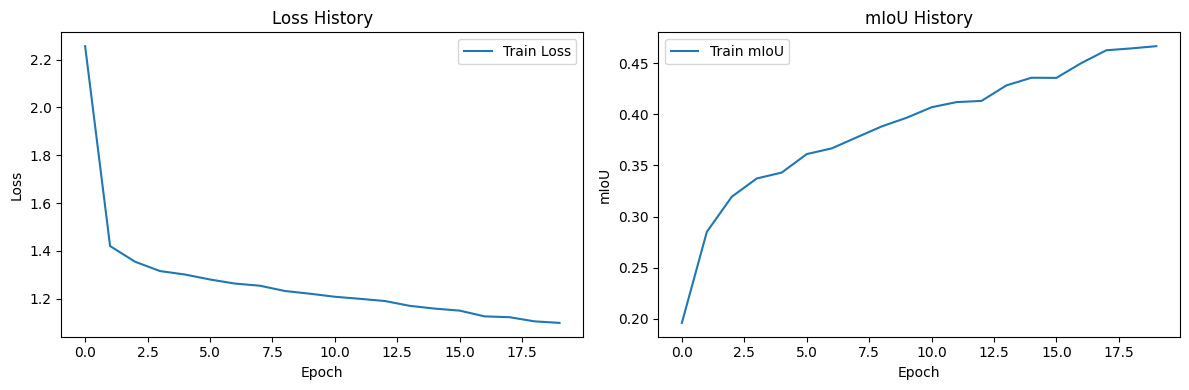

In [32]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_history['train_loss'], label='Train Loss')
#plt.plot(eval_history['val_loss'], label='Val Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_history['train_miou'], label='Train mIoU')
#plt.plot(eval_history['val_miou'], label='Val mIoU')
plt.title('mIoU History')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.legend()

plt.tight_layout()
plt.show()



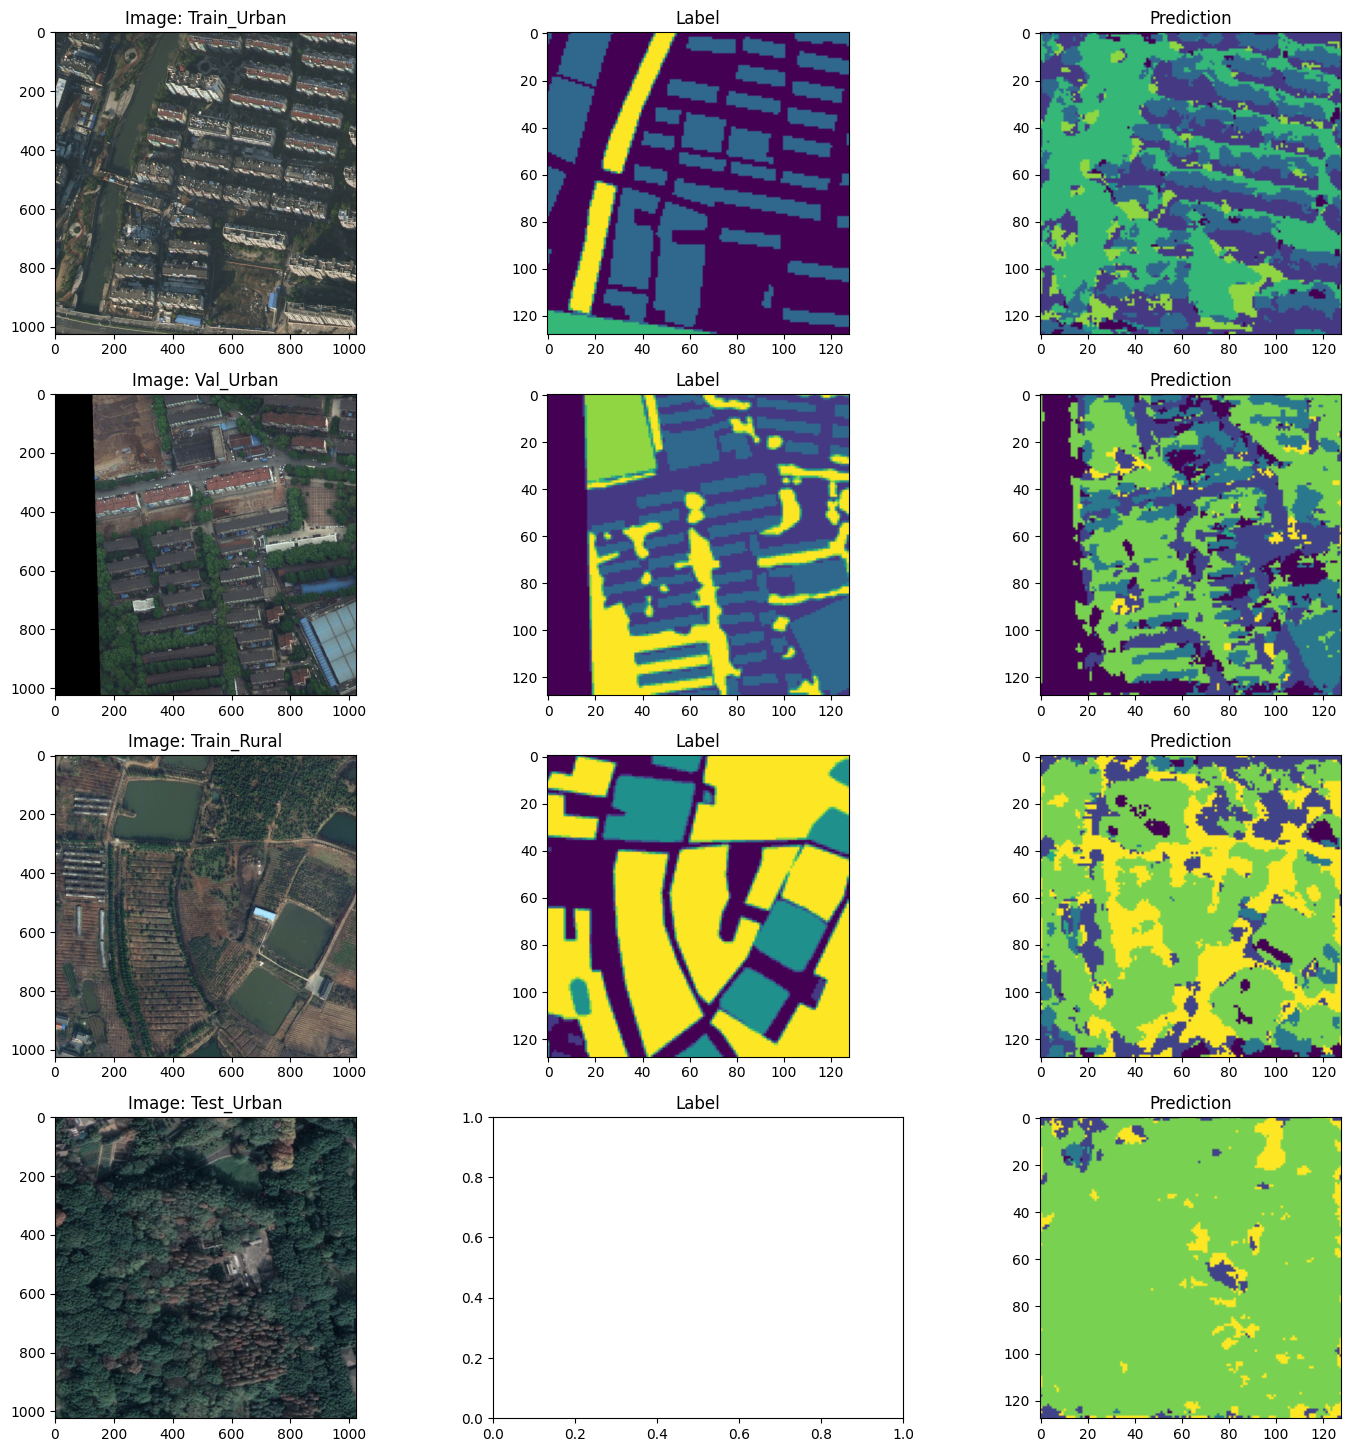

In [33]:
# Plot results
#model = get_seg_model(imgnet_pretrained = True)
#model = model.to(DEVICE)


model.eval()
im_transforms_viz = transforms.Compose([
    transforms.Resize((1024)),
    transforms.ToTensor(),

])

mask_transforms_viz = transforms.Compose([
    transforms.Resize((128)),


])

im1 = Image.open('/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation_Database/Train/Train/Urban/images_png/1521.png')
im2 = Image.open('/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation_Database/Val/Val/Urban/images_png/3618.png')
im3 = Image.open('/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation_Database/Train/Train/Rural/images_png/967.png')
im4 = Image.open('/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation_Database/Test/Test/Urban/images_png/5783.png')

mask1 = Image.open('/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation_Database/Train/Train/Urban/masks_png/1521.png')
mask2 = Image.open('/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation_Database/Val/Val/Urban/masks_png/3618.png')
mask3 = Image.open('/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation_Database/Train/Train/Rural/masks_png/967.png')

im1 = im_transforms_viz(im1)
im2 = im_transforms_viz(im2)
im3 = im_transforms_viz(im3)
im4 = im_transforms_viz(im4)

mask1 = mask_transforms_viz(mask1)
mask2 = mask_transforms_viz(mask2)
mask3 = mask_transforms_viz(mask3)

if torch.cuda.is_available():
    im1 = im1.cuda(non_blocking=True)
    #mask1 = mask1.cuda(non_blocking=True)
    im2 = im2.cuda(non_blocking=True)
    #mask2 = mask2.cuda(non_blocking=True)
    im3 = im3.cuda(non_blocking=True)
    #mask3 = mask3.cuda(non_blocking=True)
    im4 = im4.cuda(non_blocking=True)

#if opt.name_net == 'deeplab':
#    pred1 = model(im1[None,:,:,:])['out']
#    pred2 = model(im2[None,:,:,:])['out']
#    pred3 = model(im3[None,:,:,:])['out']
#else:
pred1 = model(im1[None,:,:,:])[0]
#pred1 = torch.Tensor(pred1)
pred2 = model(im2[None,:,:,:])[0]
#pred2 = torch.Tensor(pred2)
pred3 = model(im3[None,:,:,:])[0]
#pred3 = torch.Tensor(pred3)
pred4 = model(im4[None,:,:,:])[0]

pred1 = torch.squeeze(pred1)
pred1 = pred1.argmax(0).squeeze()
pred1 = pred1.cpu().detach().numpy()
pred2 = torch.squeeze(pred2)
pred2 = pred2.argmax(0).squeeze()
pred2 = pred2.cpu().detach().numpy()
pred3 = torch.squeeze(pred3)
pred3 = pred3.argmax(0).squeeze()
pred3 = pred3.cpu().detach().numpy()
pred4 = torch.squeeze(pred4)
pred4 = pred4.argmax(0).squeeze()
pred4 = pred4.cpu().detach().numpy()

fig , ax =  plt.subplots(4, 3, figsize=(18, 18))
ax[0][0].set_title('Image: Train_Urban')
ax[0][1].set_title('Label')
ax[0][2].set_title('Prediction')
ax[1][0].set_title('Image: Val_Urban')
ax[1][1].set_title('Label')
ax[1][2].set_title('Prediction')
ax[2][0].set_title('Image: Train_Rural')
ax[2][1].set_title('Label')
ax[2][2].set_title('Prediction')
ax[3][0].set_title('Image: Test_Urban')
ax[3][1].set_title('Label')
ax[3][2].set_title('Prediction')
ax[0][0].imshow(np.squeeze(np.transpose(im1.squeeze().cpu(),(1,2,0))))
ax[0][1].imshow(mask1)
ax[0][2].imshow(pred1.squeeze(), vmin = 0, vmax = 6) #v defines the color map
ax[1][0].imshow(np.squeeze(np.transpose(im2.squeeze().cpu(),(1,2,0))))
ax[1][1].imshow(mask2)
ax[1][2].imshow(pred2.squeeze())
ax[2][0].imshow(np.squeeze(np.transpose(im3.squeeze().cpu(),(1,2,0))))
ax[2][1].imshow(mask3)
ax[2][2].imshow(pred3.squeeze())
ax[3][0].imshow(np.squeeze(np.transpose(im4.squeeze().cpu(),(1,2,0))))
ax[3][1]#.imshow(mask4)
ax[3][2].imshow(pred4.squeeze())


In [ ]:
#if __name__ == '__main__':
#  main()

In [ ]:
#print(model)
#pred1 = model(im1[None,:,:,:])
#pred1 = torch.squeeze(pred1)
#pred1 = pred1.cpu().detach().numpy()
#print(pred1 )
#print(pred1.shape )
#print(pred1.argmax(1) )
#print(pred1.argmax(1).shape )

#print(pred1.argmax(1).shape)
#print(pred1.view(-1).shape)
#print(pred1.view(-1))


#print(pred1.view(-1).shape)
#print(pred1.argmax(1).shape)
#pred1 = pred1[0].argmax(1)
#print(pred1)
#print(pred1.shape)
#print(pred1.view(-1).shape)
#print(max(pred1.view(-1)))

#print( pred1([1, 128, 128]) )

#print(len(train_loader))
#mask1 = mask1.squeeze()
#print(mask1.shape)
#print(mask1.view(-1).shape)
#print(max(mask1.view(-1)))

In [ ]:
from PIL import Image
import numpy as np

# Load the mask
mask_path = "/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation_Database/Val/Val/Urban/images_png/3518.png"  # Replace with the correct path
mask = Image.open(mask_path).convert('L')
mask_array = np.array(mask)
num_classes = 7
mask_normalized = (mask_array / (255 / (num_classes - 1))).round().astype(np.int64)

# Convert to a PyTorch tensor
mask = torch.as_tensor(mask_normalized, dtype=torch.long)
#mask = mask
print("Unique values in the normalized mask:", np.unique(mask))
print("Shape ",mask.shape)
mask = mask.resize_(32,32)
print("Shape ",mask.shape)
print("Unique values in the normalized mask:", np.unique(mask))

In [ ]:
mask_path = "/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation_Database/Val/Val/Urban/images_png/3518.png"
mask = Image.open(mask_path).convert('L')

# Normalize the mask to class indices
mask_array = np.array(mask)
num_classes = 7
mask_normalized = (mask_array / (255 / (num_classes - 1))).round().astype(np.int64)
mask_tensor = torch.as_tensor(mask_normalized, dtype=torch.long).unsqueeze(0)  # Add channel dimension

# Apply resizing
resize_transform = transforms.Resize((32, 32), interpolation=transforms.InterpolationMode.NEAREST)
resized_mask = resize_transform(mask_tensor)

# Check unique values
print("Unique values in resized mask:", torch.unique(resized_mask))

In [ ]:
image, mask = train_dataset[0]  # Get a sample from the dataset
print("Unique values in the mask:", np.unique(mask))

In [34]:
model.eval()
# Task 3a
#Training set - Urban
#Validation set - Rural
VAL_IMAGE_DIR = ('/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation_Database/Val/Val/Rural/images_png')
VAL_MASK_DIR = ('/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation_Database/Val/Val/Rural/masks_png')


In [ ]:
'''#Data Augmentation
import albumentations as A

def get_train_augs():
  return A.Compose([
      #A.Resize(IMG_SIZE, IMG_SIZE), #IMG_SIZE already defined above
      A.HorizontalFlip(p=0.5), #Probability of Horizontal Flip
      #A.VerticalFlip(p=0.5) #Probability of Horizontal Flip
      A.GaussianBlur(blur_limit=(3,7), p=0.5)
  ])
  #Label doesn't change when augmentation is changed. So flip doesn't have any effect on label

  # FOR SEGMENTATION< THIS IS DIFFERENT. IT DOES HAVE AN EFFECT!!!!!!! This is why we use this library
'''

'''
def get_valid_aug():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ]) # We only resize. No other augmentation done
'''

In [35]:
'''train_dataset = SemanticSegmentationDataset(
    image_dir= IMAGE_DIR,
    mask_dir= MASK_DIR,
    transform=image_transform,
    mask_transform=mask_transform,
    augmentations = get_train_augs()

)
'''
val_dataset = SemanticSegmentationDataset(
    image_dir= VAL_IMAGE_DIR,
    mask_dir= VAL_MASK_DIR,
    transform=image_transform,
    mask_transform=mask_transform
    #get_train_augs()

)
'''
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if DEVICE=='cuda' else False
)
'''
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if DEVICE=='cuda' else False
)
'''
train_history = train_model(model, train_loader, criterion,
                      optimizer, NUM_EPOCHS, DEVICE)
'''
validation_history = eval_model(model, val_loader, criterion,
                      optimizer, NUM_EPOCHS, DEVICE)



Validation Epoch: 1/1 : 100%|██████████| 59/59 [12:16<00:00, 12.48s/it]

Val Loss: 1.497094, Val mIoU: 0.137150 



In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
#plt.plot(train_history['train_loss'], label='Train Loss')
plt.plot(validation_history['val_loss'], label='Val Loss RURAL DATASET')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
#plt.plot(train_history['train_miou'], label='Train mIoU')
plt.plot(validation_history['val_miou'], label='Val mIoU RURAL DATASET')
plt.title('mIoU History')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print(train_history['train_loss'])
print(train_history['train_miou'])
print(eval_history['val_loss'])
print(eval_history['val_miou'])
print(validation_history['val_loss'])
print(validation_history['val_miou'])

In [ ]:
# Plot results
#model = get_seg_model(imgnet_pretrained = True)
#model = model.to(DEVICE)


model.eval()
im_transforms_viz = transforms.Compose([
    transforms.Resize((1024)),
    transforms.ToTensor(),

])

mask_transforms_viz = transforms.Compose([
    transforms.Resize((128)),


])

im1 = Image.open('/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation_Database/Train/Train/Urban/images_png/1521.png')
im2 = Image.open('/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation_Database/Val/Val/Urban/images_png/3618.png')
im3 = Image.open('/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation_Database/Train/Train/Rural/images_png/967.png')
im4 = Image.open('/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation_Database/Test/Test/Urban/images_png/5783.png')

mask1 = Image.open('/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation_Database/Train/Train/Urban/masks_png/1521.png')
mask2 = Image.open('/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation_Database/Val/Val/Urban/masks_png/3618.png')
mask3 = Image.open('/content/drive/MyDrive/Colab Notebooks/Semantic_Segmentation_Database/Train/Train/Rural/masks_png/967.png')

im1 = im_transforms_viz(im1)
im2 = im_transforms_viz(im2)
im3 = im_transforms_viz(im3)
im4 = im_transforms_viz(im4)

mask1 = mask_transforms_viz(mask1)
mask2 = mask_transforms_viz(mask2)
mask3 = mask_transforms_viz(mask3)

if torch.cuda.is_available():
    im1 = im1.cuda(non_blocking=True)
    #mask1 = mask1.cuda(non_blocking=True)
    im2 = im2.cuda(non_blocking=True)
    #mask2 = mask2.cuda(non_blocking=True)
    im3 = im3.cuda(non_blocking=True)
    #mask3 = mask3.cuda(non_blocking=True)
    im4 = im4.cuda(non_blocking=True)

#if opt.name_net == 'deeplab':
#    pred1 = model(im1[None,:,:,:])['out']
#    pred2 = model(im2[None,:,:,:])['out']
#    pred3 = model(im3[None,:,:,:])['out']
#else:
pred1 = model(im1[None,:,:,:])[0]
#pred1 = torch.Tensor(pred1)
pred2 = model(im2[None,:,:,:])[0]
#pred2 = torch.Tensor(pred2)
pred3 = model(im3[None,:,:,:])[0]
#pred3 = torch.Tensor(pred3)
pred4 = model(im4[None,:,:,:])[0]

pred1 = torch.squeeze(pred1)
pred1 = pred1.argmax(0).squeeze()
pred1 = pred1.cpu().detach().numpy()
pred2 = torch.squeeze(pred2)
pred2 = pred2.argmax(0).squeeze()
pred2 = pred2.cpu().detach().numpy()
pred3 = torch.squeeze(pred3)
pred3 = pred3.argmax(0).squeeze()
pred3 = pred3.cpu().detach().numpy()
pred4 = torch.squeeze(pred4)
pred4 = pred4.argmax(0).squeeze()
pred4 = pred4.cpu().detach().numpy()

fig , ax =  plt.subplots(4, 3, figsize=(18, 18))
ax[0][0].set_title('Image: Train_Urban')
ax[0][1].set_title('Label')
ax[0][2].set_title('Prediction')
ax[1][0].set_title('Image: Val_Urban')
ax[1][1].set_title('Label')
ax[1][2].set_title('Prediction')
ax[2][0].set_title('Image: Train_Rural')
ax[2][1].set_title('Label')
ax[2][2].set_title('Prediction')
ax[3][0].set_title('Image: Test_Urban')
ax[3][1].set_title('Label')
ax[3][2].set_title('Prediction')
ax[0][0].imshow(np.squeeze(np.transpose(im1.squeeze().cpu(),(1,2,0))))
ax[0][1].imshow(mask1)
ax[0][2].imshow(pred1.squeeze(), vmin = 0, vmax = 6) #v defines the color map
ax[1][0].imshow(np.squeeze(np.transpose(im2.squeeze().cpu(),(1,2,0))))
ax[1][1].imshow(mask2)
ax[1][2].imshow(pred2.squeeze())
ax[2][0].imshow(np.squeeze(np.transpose(im3.squeeze().cpu(),(1,2,0))))
ax[2][1].imshow(mask3)
ax[2][2].imshow(pred3.squeeze())
ax[3][0].imshow(np.squeeze(np.transpose(im4.squeeze().cpu(),(1,2,0))))
ax[3][1]#.imshow(mask4)
ax[3][2].imshow(pred4.squeeze())
